In [1]:
import os 
os.chdir('/home/enmartz/Projects/hdsp/colibri-hdsp')

Demo CASSI Reconstruction

In [2]:
#General imports
import os

import matplotlib.pyplot as plt
import torch
import lightning as L
import torchmetrics

from torchvision.utils import make_grid
from tqdm import tqdm

from colibri_hdsp.archs import E2E
from colibri_hdsp.data.datasets import Dataset
from colibri_hdsp.models import build_network, Unet
from colibri_hdsp.optics.cassi import CASSI

# Check GPU support
print("GPU support: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU support:  True


Load Dataset

In [3]:
dataset_path = 'cifar10'
keys = ''
batch_size = 128

dataset = Dataset(dataset_path, keys, batch_size)

Loading dataset:  cifar10
Files already downloaded and verified
Files already downloaded and verified


Visualize samples

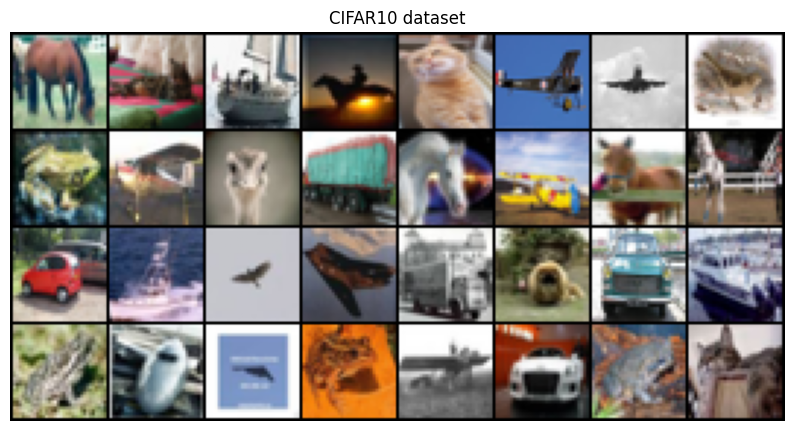

In [4]:
sample = next(iter(dataset.train_dataset))[0]
img = make_grid(sample[:32], nrow=8, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.title('CIFAR10 dataset')
plt.axis('off')
plt.show()

Optics Layer

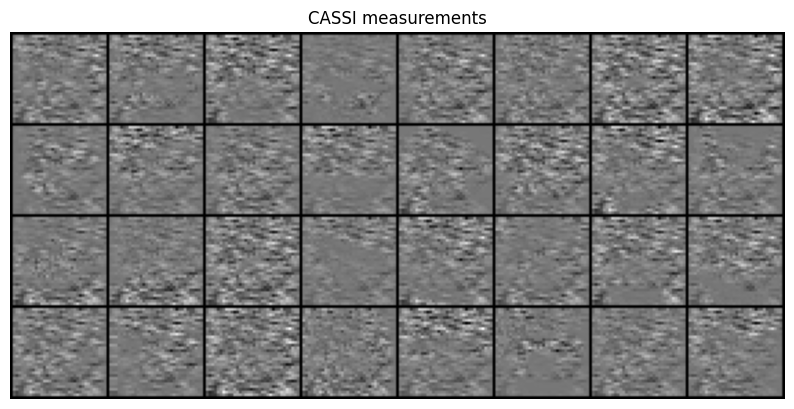

In [5]:
mode = 'base' # Type of CASSi optical system
cassi =  CASSI(sample.shape[1:], mode,  trainable=True) # CASSI layer
y = cassi(sample) # CASSI measurements

img = make_grid(y[:32], nrow=8, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)


plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title('CASSI measurements')
plt.show()

Model Class

In [25]:
class ModelE2E(L.LightningModule):
    def __init__(self, optical_encoder, computational_decoder):
        super().__init__()
        self.optical_encoder = optical_encoder
        self.computational_decoder = computational_decoder

        self.e2e_model = E2E(self.optical_encoder, self.computational_decoder)
        
        self.mse = torch.nn.MSELoss()
        self.mae = torchmetrics.MeanAbsoluteError()
        self.psnr = torchmetrics.image.PeakSignalNoiseRatio(data_range=1.0)
        self.ssim = torchmetrics.image.StructuralSimilarityIndexMeasure(data_range=1.0)
        self.sam = torchmetrics.functional.spectral_angle_mapper


    def configure(self, loss_fn=None, dict_metrics=None):
        self.loss_fn = loss_fn
        self.dict_metrics = dict_metrics

    def general_step(self, mode, batch, batch_idx):
        x, y = batch
        x, y = x.half(), y.half()

        x_hat = self.e2e_model(x)
        loss = self.mse(x_hat, x)

        mae_loss = self.mae(x_hat, x)
        psnr_loss = self.psnr(x_hat, x)
        ssim_loss = self.ssim(x_hat, x)
        sam_loss = self.sam(x_hat, torch.clamp(x, 1e-8))  # avoid nan (division by zero)

        self.log_dict({f'{mode}_loss': loss,
                       f'{mode}_mae': mae_loss,
                       f'{mode}_psnr': psnr_loss,
                       f'{mode}_ssim': ssim_loss,
                       f'{mode}_sam': sam_loss}, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.general_step('train', batch, batch_idx)

    # reset metrics
    def on_train_epoch_end(self):
        self.mae.reset()
        self.psnr.reset()
        self.ssim.reset()

    def validation_step(self, batch, batch_idx):
        return self.general_step('val', batch, batch_idx)

    # reset metrics
    def on_validation_epoch_end(self, *args, **kwargs):
        self.mae.reset()
        self.psnr.reset()
        self.ssim.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

Build Model

In [26]:
computational_decoder = build_network(Unet, in_channels=cassi.L, out_channels=cassi.L)
model = ModelE2E(cassi, computational_decoder)

Training Loop

In [27]:
torch.set_float32_matmul_precision('high')
trainer = L.Trainer(max_epochs=10, logger=[], precision='16-mixed', callbacks=[])
trainer.fit(model, dataset.train_dataset, val_dataloaders=dataset.test_dataset)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                             | Params
---------------------------------------------------------------------------
0 | optical_encoder       | CASSI                            | 1.0 K 
1 | computational_decoder | Unet                             | 1.8 M 
2 | e2e_model             | E2E                              | 1.8 M 
3 | mse                   | MSELoss                          | 0     
4 | mae                   | MeanAbsoluteError                | 0     
5 | psnr                  | PeakSignalNoiseRatio             | 0     
6 | ssim                  | StructuralSimilarityIndexMeasure | 0     
---------------------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainabl

/home/enmartz/anaconda3/envs/pt2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/enmartz/anaconda3/envs/pt2/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
/home/enmartz/anaconda3/envs/pt2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

Epoch 9: 100%|██████████| 391/391 [00:17<00:00, 22.05it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 391/391 [00:17<00:00, 22.00it/s]


Visualize results

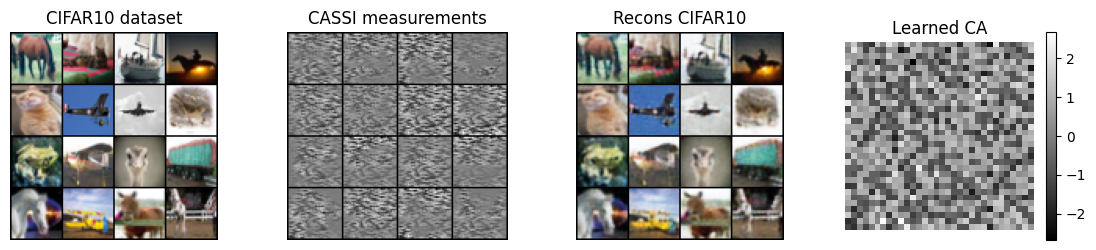

In [41]:
x_est = model.e2e_model(sample)
y_cassi = cassi(sample)

img      = make_grid(sample[:16], nrow=4, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)
img_est  = make_grid(x_est[:16], nrow=4, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)
img_casi = make_grid(y_cassi[:16], nrow=4, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)

imgs_dict = {
    "CIFAR10 dataset": img, 
    "CASSI measurements": img_casi,
    "Recons CIFAR10": img_est
}

plt.figure(figsize=(14, 2.7))

for i, (title, img) in enumerate(imgs_dict.items()):
    plt.subplot(1, 4, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

ca = cassi.ca.cpu().detach().numpy().squeeze()

plt.subplot(1, 4, 4)
plt.imshow(ca, cmap='gray')
plt.axis('off')
plt.title('Learned CA')
plt.colorbar()

plt.show()